In [34]:
from collections import Counter
import json
import requests, sys, os
import time
import xmltodict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [72]:
annotations_path = "./annotations/"
annotations = os.listdir(annotations_path)
annotations = [file for file in annotations if file.endswith(".vcf")]

In [73]:
df = pd.DataFrame()

for annotation in tqdm(annotations):
    
    data = []

    with open(f"annotations/{annotation}", "r") as f:
        for line in f.readlines():
                data.append(line.strip().split("\t"))

    column_names = data[0]
    data = data[1:]
                
    df_tmp = pd.DataFrame(data, columns=column_names)
    
    df_tmp["ID_WGS"] = annotation.split(".")[0].split("_")[-1]
    df_tmp = df_tmp[["ID_WGS", "Chromosome", "Start", "End", "Type", "Classification", "All protein coding genes"]]
    df_tmp.rename(columns={"All protein coding genes": "Protein_coding_genes"}, inplace=True)
    df_tmp.dropna(subset=["Protein_coding_genes"], inplace=True)
    
    df = pd.concat([df, df_tmp], axis=0)

df = df.reset_index(drop=True)
df.to_csv("results/all_annotated_cnv.csv", index=False)

100%|██████████| 387/387 [00:03<00:00, 109.72it/s]


In [74]:
df_pheno = pd.read_csv("data/phenotype_WGS.csv")
df_pheno.rename(columns={"Snumber": "ID_WGS"}, inplace=True)
df_pheno

,ID_WGS,UID,Code,Conversion_Psychosis,Phenotype
0,S36739,IC01001,UHR,C,Converter
1,S36740,IC01004,SCZ,NaN,FEP
2,S36741,IC01006,UHR,NaN,UHR
3,S36742,IC01010,UHR,C,Converter
4,S36743,IC01012,UHR,NC,Non_converter
...,...,...,...,...,...
395,S36989,STR01-032-MM-I,UHR,NC,Non_converter
396,S36990,STR01-033-CE-I,UHR,C,Converter
397,S36991,STR01-034-MT-I,UHR,C,Converter
398,S36992,STR01-039-DL-I,UHR,NC,Non_converter


In [75]:
print("No genetic data for:", end=" ")

wgs_ids = []

for id in df_pheno["ID_WGS"].to_list():
    if id not in df["ID_WGS"].to_list():
        wgs_ids.append(id)

print(", ".join(wgs_ids))

No genetic data for: S36739, S36740, S36741, S36746, S36751, S36797, S36807, S36809, S36848, S36997, S36944, S37071, S37088


In [76]:
for id in df["ID_WGS"]:
    df_index = df["ID_WGS"] == id
    pheno_index = df_pheno["ID_WGS"] == id
    column_names = ["Code", "Phenotype"]
    for column in column_names:
        df.loc[df_index, column] = df_pheno.loc[pheno_index, column].values[0]

df = df[["ID_WGS", "Code", "Phenotype", "Chromosome", "Start", "End", "Type", "Classification", "Protein_coding_genes"]]
df.to_csv("results/cnv_phenotypes.csv", index=False)  
df

/tmp/ipykernel_1277/1696000361.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'UHR' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df_index, column] = df_pheno.loc[pheno_index, column].values[0]
/tmp/ipykernel_1277/1696000361.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Converter' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df_index, column] = df_pheno.loc[pheno_index, column].values[0]


,ID_WGS,Code,Phenotype,Chromosome,Start,End,Type,Classification,Protein_coding_genes
0,S36742,UHR,Converter,chr10,46514588,46561948,DUP,Uncertain significance,GPRIN2
1,S36742,UHR,Converter,chr11,18922801,18942182,DEL,Benign,MRGPRX1
2,S36742,UHR,Converter,chr11,56697855,56707946,DUP,Uncertain significance,"OR9G1, OR9G9"
3,S36742,UHR,Converter,chr11,5763025,5788170,DEL,Benign,"OR52N5, OR52N1"
4,S36742,UHR,Converter,chr11,59043182,59086423,DEL,Uncertain significance,GLYATL1B
...,...,...,...,...,...,...,...,...,...
18397,S37138,FEP,FEP,chr6,32577150,32589674,DUP,Uncertain significance,HLA-DRB1
18398,S37138,FEP,FEP,chr6,35785866,35798560,DUP,Benign,"CLPSL1, CLPS"
18399,S37138,FEP,FEP,chr6,72153159,72165061,DEL,Benign,RIMS1
18400,S37138,FEP,FEP,chr7,100955671,100971252,DUP,Uncertain significance,"MUC3A, MUC12"


In [7]:
set(df_pathogen["Protein_coding_genes"].values.tolist())

{'ADGRB1, ARC, JRK, PSCA, LY6K, THEM6, SLURP1, LYPD2, SLURP2, LYNX1-SLURP2, LYNX1, LY6D, GML, CYP11B1, CYP11B2, LY6E, LY6L, LY6H, GPIHBP1, ZFP41, GLI4, ZNF696, TOP1MT, RHPN1, MAFA, ZC3H3, GSDMD, MROH6, NAPRT, EEF1D, TIGD5, PYCR3, TSTA3, ZNF623, ZNF707, CCDC166, MAPK15, FAM83H, SCRIB, PUF60, NRBP2, EPPK1, PLEC, PARP10, GRINA, SPATC1, OPLAH, EXOSC4, GPAA1, CYC1, SHARPIN, MAF1, WDR97, HGH1, MROH1, BOP1, SCX, HSF1, DGAT1, SCRT1, TMEM249, FBXL6, SLC52A2, ADCK5, CPSF1, SLC39A4, VPS28, TONSL, CYHR1, KIFC2, FOXH1, PPP1R16A, GPT, MFSD3, RECQL4, LRRC14, LRRC24, C8orf82, ARHGAP39, ZNF251, ZNF34, RPL8, ZNF517, ZNF7, COMMD5, ZNF250, ZNF16, C8orf33',
 'CDKN2A',
 'FBXO43, POLR2K, SPAG1, RNF19A, ANKRD46, SNX31, PABPC1, YWHAZ, ZNF706, GRHL2, NCALD, RRM2B, UBR5, ODF1, KLF10, AZIN1, ATP6V1C1, BAALC, FZD6, CTHRC1, SLC25A32, DCAF13, RIMS2, DCSTAMP, DPYS, LRP12, CIBAR1, RBM12B, TMEM67, PDP1, CDH17, GEM, RAD54B, FSBP, VIRMA, ESRP1, DPY19L4, INTS8, CCNE2, TP53INP1, NDUFAF6, PLEKHF2, C8orf37, GDF6, UQCRB, MTER

In [8]:
for id in tqdm(df["ID_WGS"]):
    genes = []
    df_index = df["ID_WGS"] == id
    genes.extend(df.loc[df_index, "Protein_coding_genes"].to_list())
    
    df_pheno_index = df_pheno["ID_WGS"] == id
    df_pheno.loc[df_pheno_index, "Protein_coding_genes"] = ', '.join(genes)
    
df_pheno.to_csv("results/genes_and_phenotypes.csv", index=False)
df_pheno

  0%|          | 0/18402 [00:00<?, ?it/s]/tmp/ipykernel_1115/1849754180.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPRIN2, MRGPRX1, OR9G1, OR9G9, OR52N5, OR52N1, GLYATL1B, PRH1, PRH1-TAS2R14, TAS2R43, CACNA1C, SLC16A7, HEATR4, ACOT1, SCAPER, PDXDC1, CES1, PDPR, MAP2K3, KCNJ18, CCL3L3, CCL3L1, CCL4L1, CCL4L2, KRTAP9-6, LOXHD1, ST8SIA5, PSG4, SIGLEC14, ZNF324B, ZNF324, GSTM1, LCE3C, LCE3B, NBPF1, CROCC, CFHR3, CFHR1, RHD, SIRPB1, TPTE, SESTD1, ALG1L2, MUC20, FRG2C, UGT2B10, FAM90A26, USP17L10, PCDHA1, PCDHA2, PCDHA3, PCDHA4, PCDHA5, PCDHA6, PCDHA7, PCDHA8, PCDHA9, PCDHA10, DUSP22, HLA-DRB5, CLPSL1, CLPS, RIMS1, ZAN, MUC3A, MUC12, TARP, ASMT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_pheno.loc[df_pheno_index, "Protein_coding_genes"] = ', '.join(genes)
100%|██████████| 18402/18402 [00:34<00:00, 541.06it/s]


,ID_WGS,UID,Code,Conversion_Psychosis,Phenotype,Protein_coding_genes
0,S36739,IC01001,UHR,C,Converter,NaN
1,S36740,IC01004,SCZ,NaN,FEP,NaN
2,S36741,IC01006,UHR,NaN,UHR,NaN
3,S36742,IC01010,UHR,C,Converter,"GPRIN2, MRGPRX1, OR9G1, OR9G9, OR52N5, OR52N1,..."
4,S36743,IC01012,UHR,NC,Non_converter,"ANTXRL, GPRIN2, DLG5, POLR3A, RPS24, MRGPRX1, ..."
...,...,...,...,...,...,...
395,S36989,STR01-032-MM-I,UHR,NC,Non_converter,"FANK1, ANTXRL, GPRIN2, MCU, MRGPRX1, OR4C11, O..."
396,S36990,STR01-033-CE-I,UHR,C,Converter,"FANK1, GPRIN2, MRGPRX1, OR4C11, OR4P4, OR4S2, ..."
397,S36991,STR01-034-MT-I,UHR,C,Converter,"FANK1, GPRIN2, MRGPRX1, OR9G1, OR9G9, PRH1, PR..."
398,S36992,STR01-039-DL-I,UHR,NC,Non_converter,"FANK1, GPRIN2, PCDH15, SLC35F2, OR9G1, OR9G9, ..."


/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

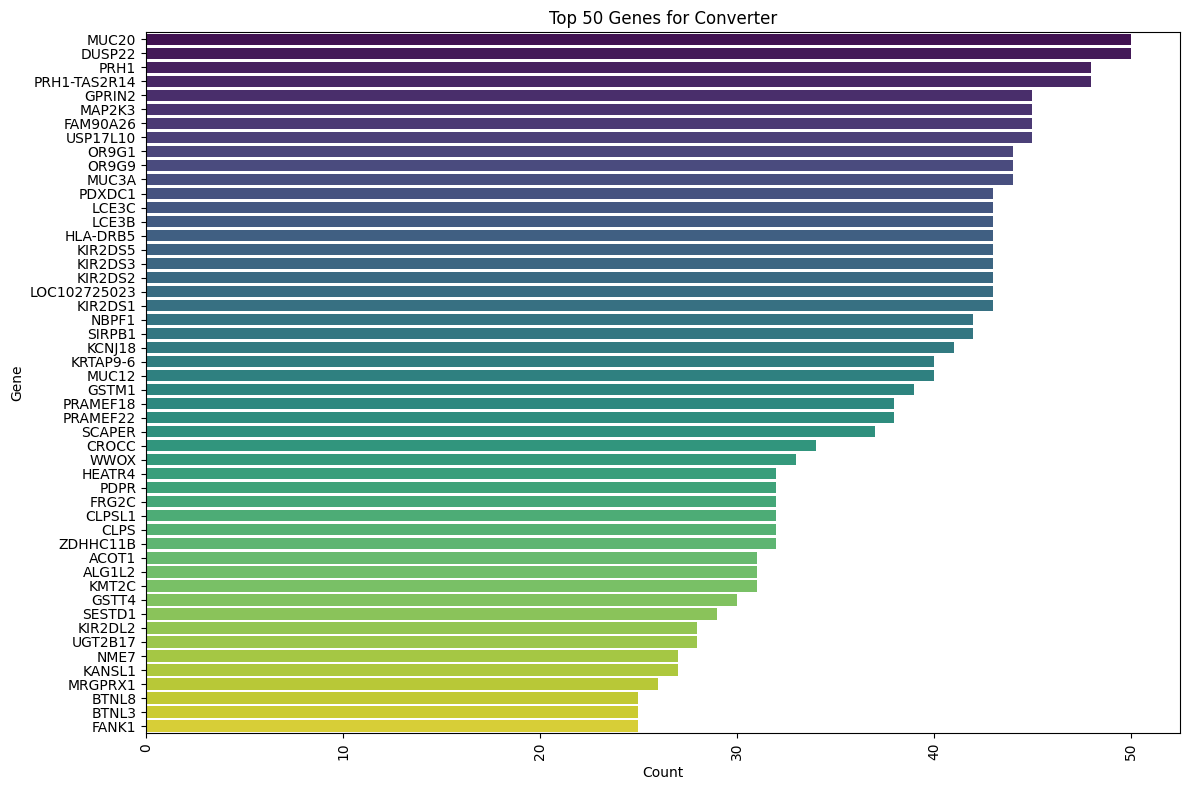

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

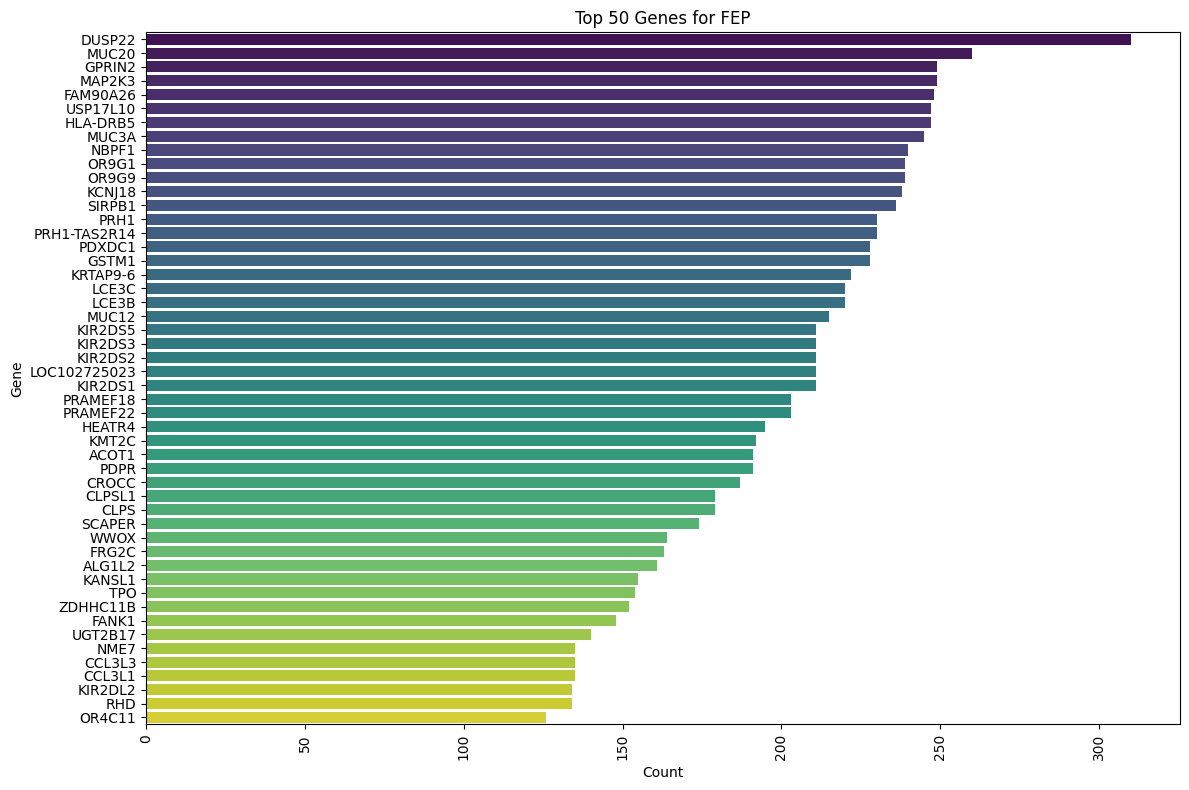

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

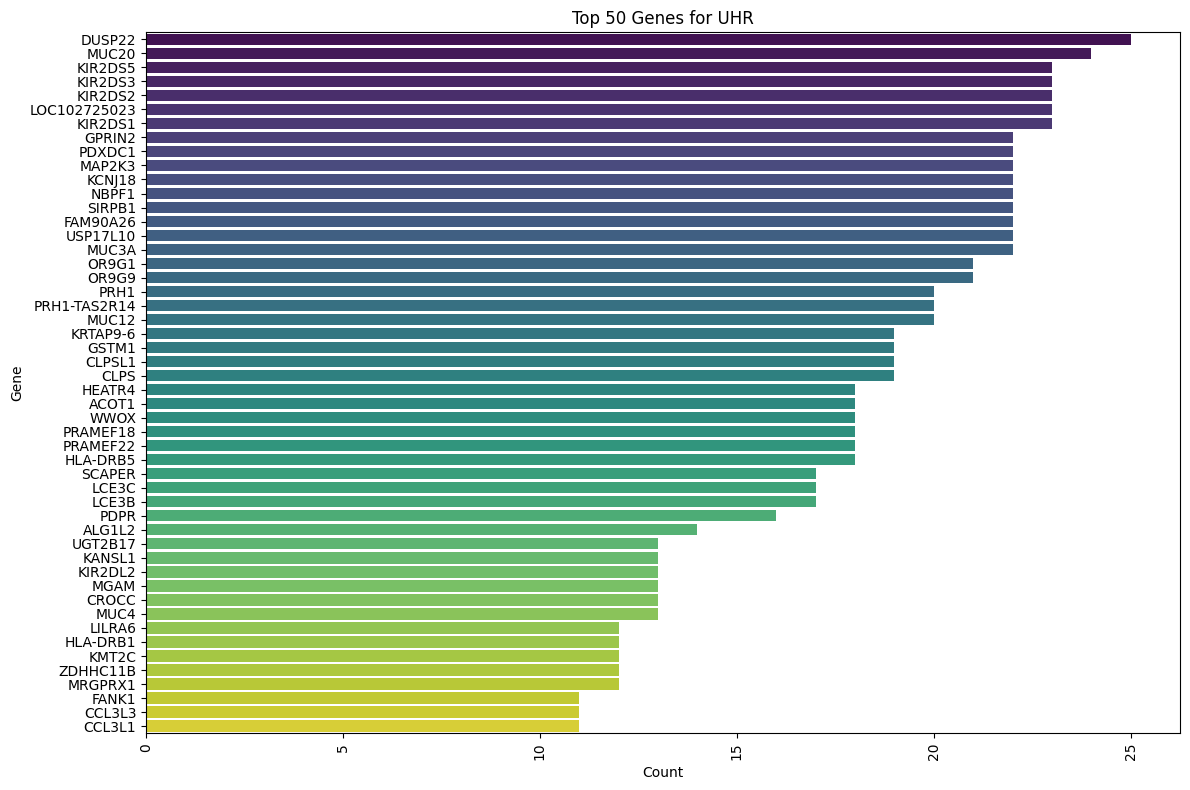

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

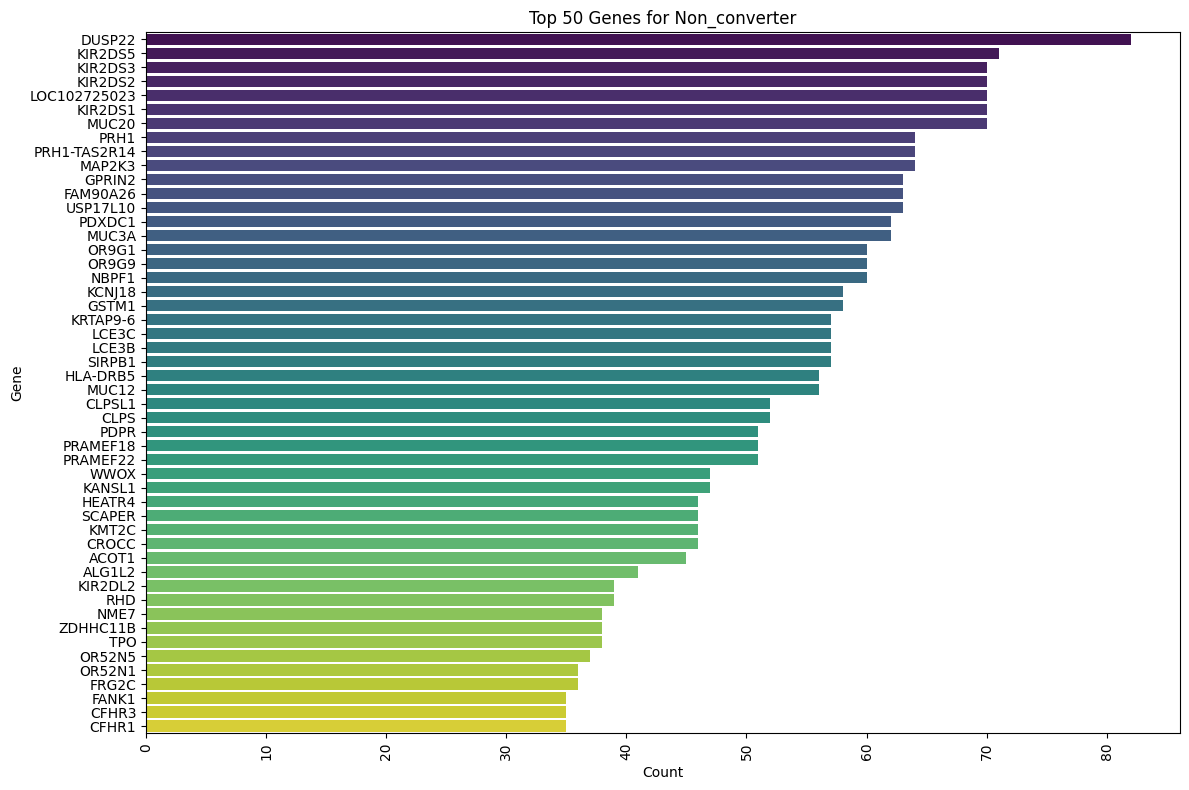

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

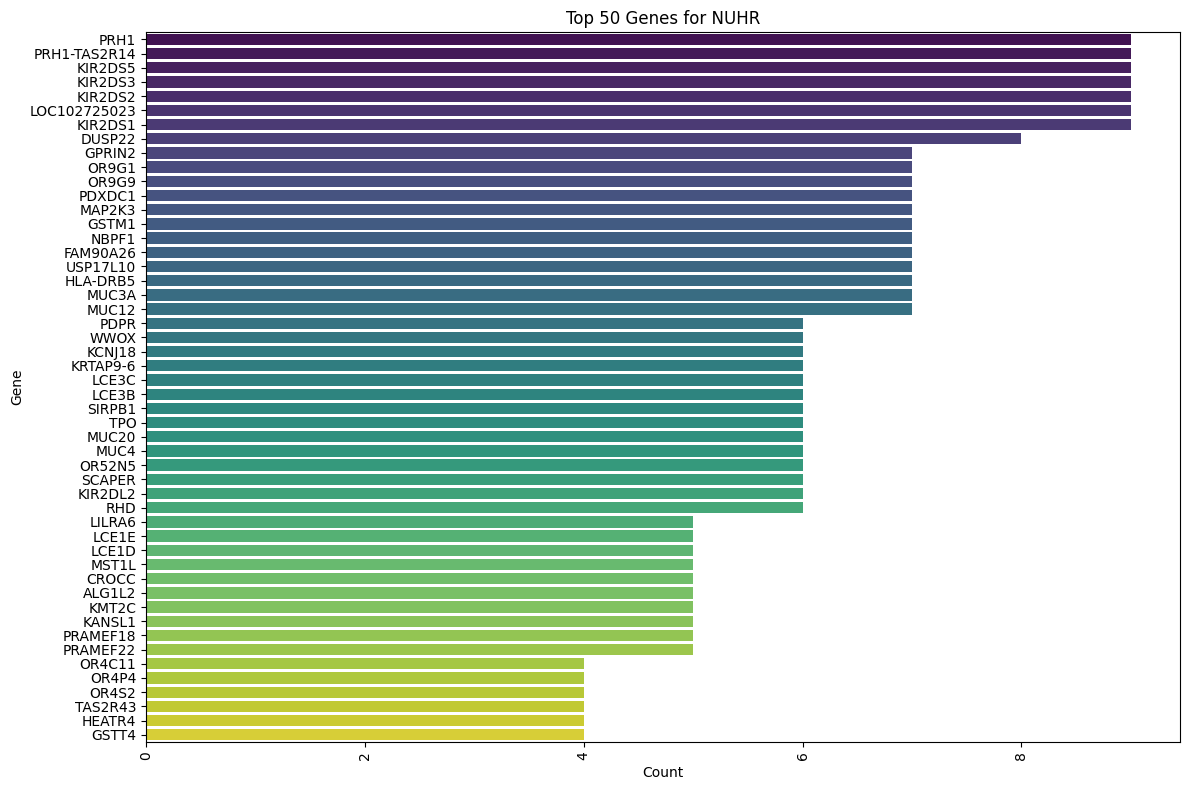

In [9]:
gene_counts_by_phenotype = {}

unique_phenotypes = df_pheno['Phenotype'].unique()[:-1]
for phenotype in unique_phenotypes:
    phenotype_df = df_pheno[df_pheno['Phenotype'] == phenotype]
    all_genes = [gene for genes_list in phenotype_df['Protein_coding_genes'] for gene in str(genes_list).split(', ')]
    gene_counts = Counter(all_genes)
    gene_counts_by_phenotype[phenotype] = gene_counts

top_N = 50

for phenotype, gene_counts in gene_counts_by_phenotype.items():
    top_genes = gene_counts.most_common(top_N)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=[count for _, count in top_genes], y=[gene for gene, _ in top_genes], palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Gene')
    plt.title(f'Top {top_N} Genes for {phenotype}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [10]:
with open("results/gene_counts_by_phenotype.json", "w") as f:
    json.dump(gene_counts_by_phenotype, f)

### Analyse statistique des genes entre les converteurs, non converteurs et uhr

In [11]:
df_pheno.dropna(subset=["Protein_coding_genes"], inplace=True)

In [12]:
genes = [genes.split(", ") for genes in df_pheno["Protein_coding_genes"]]
all_genes = list(set([gene for gene_list in genes for gene in gene_list]))
len(all_genes)

2437

In [13]:
converters = ["FEP", "Converter"]
non_converters = ["NUHR", "Non-converter"]
uhr = ["UHR"]

In [19]:
gene_freq_converters = {}
gene_freq_non_converters = {}
gene_freq_uhr = {}

for gene in all_genes:
    gene_freq_converters[gene] = 0
    gene_freq_non_converters[gene] = 0
    gene_freq_uhr[gene] = 0
    
for sujet in tqdm(df_pheno["ID_WGS"]):
    sujet_index = df_pheno["ID_WGS"] == sujet
    sujet_genes = df_pheno.loc[sujet_index, "Protein_coding_genes"].values[0].split(", ")
    sujet_phenotype = df_pheno.loc[sujet_index, "Phenotype"].values[0]
    
    if sujet_phenotype in converters:
        for gene in sujet_genes:
            gene_freq_converters[gene] += 1
    elif sujet_phenotype in non_converters:
        for gene in sujet_genes:
            gene_freq_non_converters[gene] += 1
    elif sujet_phenotype in uhr:
        for gene in sujet_genes:
            gene_freq_uhr[gene] += 1

NameError: name 'all_genes' is not defined

In [15]:
for gene in all_genes:
    gene_freq_converters[gene] /= sum(gene_freq_converters.values())
    gene_freq_non_converters[gene] /= sum(gene_freq_non_converters.values())
    gene_freq_uhr[gene] /= sum(gene_freq_uhr.values())

In [20]:
df_contig = pd.DataFrame({'converters': gene_freq_converters.values(), 
                   'non_converters': gene_freq_non_converters.values(), 
                   'uhr': gene_freq_uhr.values()}, index=gene_freq_uhr.keys())


In [24]:
df_contig.to_csv("results/contigency_table.csv")

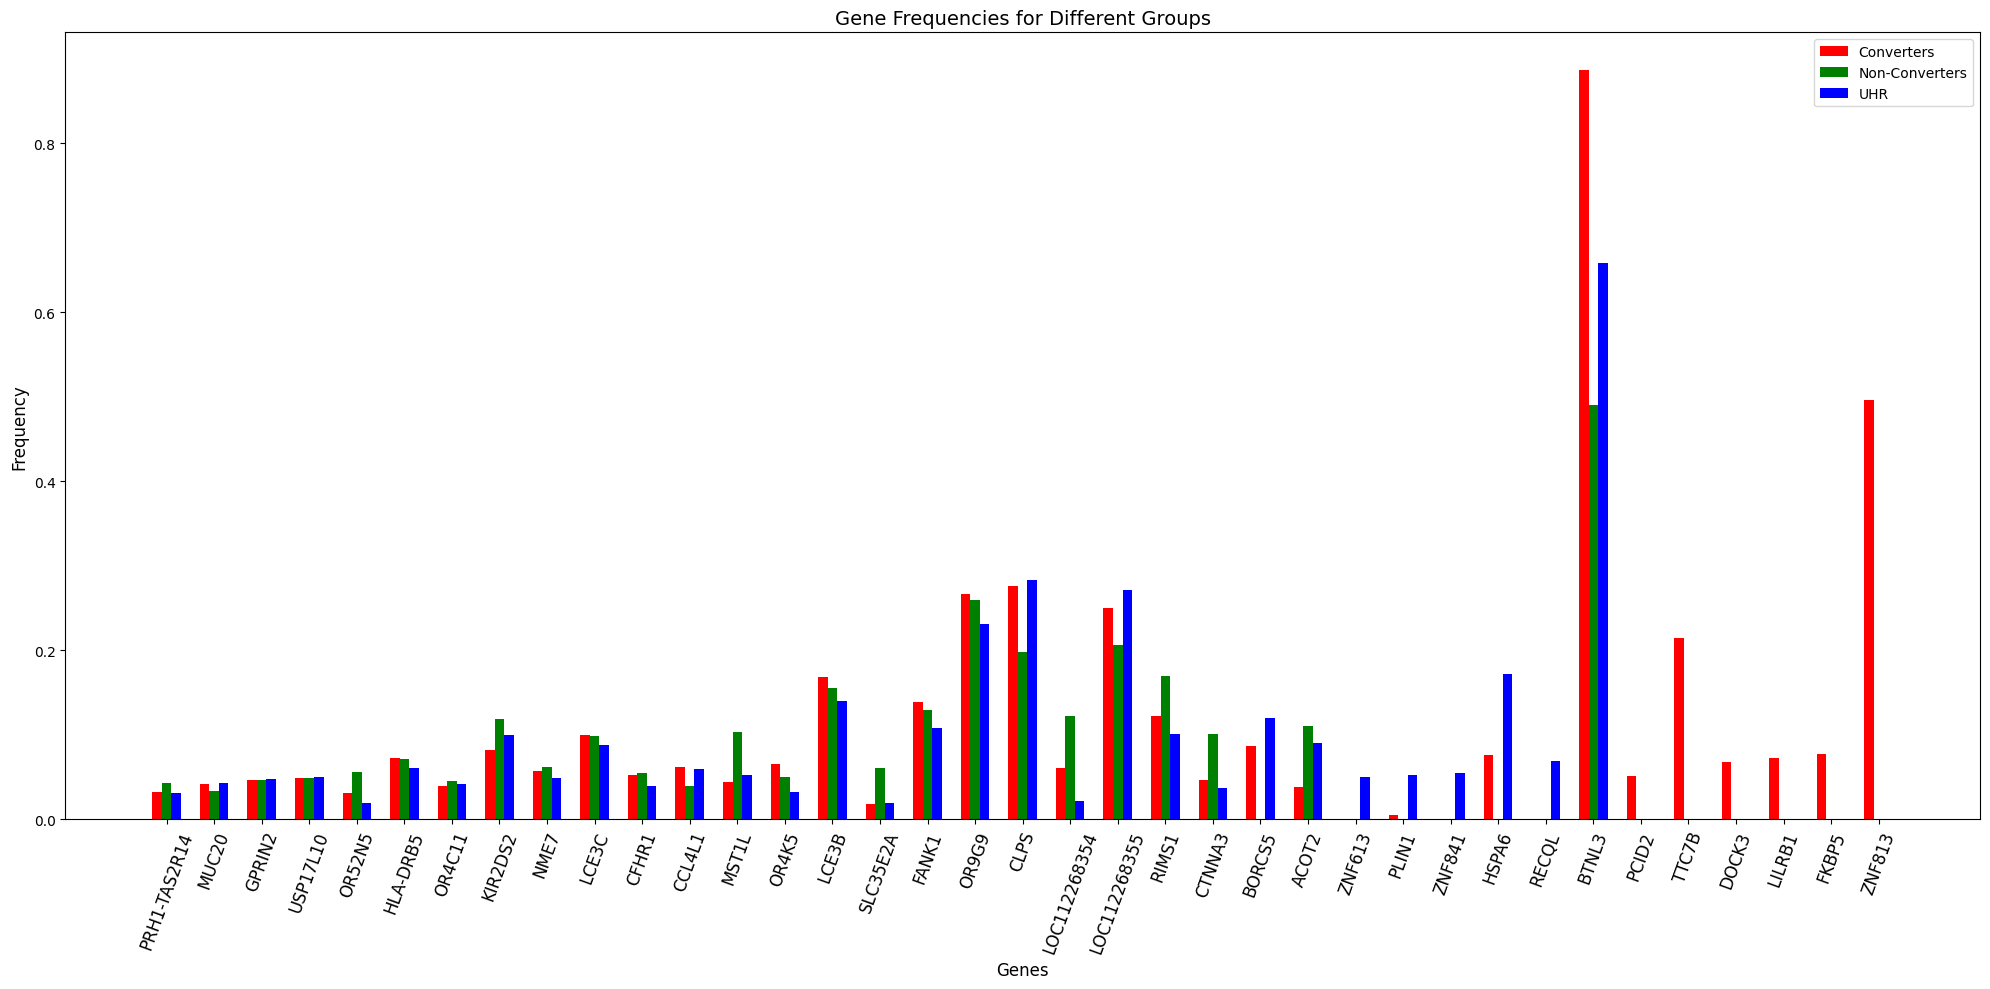

In [17]:
threshold = 0.04

filtered_df = df_contig[(df_contig['converters'] > threshold) |
                        (df_contig['non_converters'] > threshold) |
                        (df_contig['uhr'] > threshold)]

num_genes = len(filtered_df)
x_positions = range(num_genes)
bar_width = 0.2 

plt.figure(figsize=(20, 10))

plt.bar(x_positions, filtered_df['converters'], label='Converters', width=bar_width, color='red', align='center')
plt.bar([x + bar_width for x in x_positions], filtered_df['non_converters'], label='Non-Converters', width=bar_width, color='green', align='center')
plt.bar([x + 2 * bar_width for x in x_positions], filtered_df['uhr'], label='UHR', width=bar_width, color='blue', align='center')

plt.xticks([x + bar_width for x in x_positions], filtered_df.index, rotation=70, fontsize=12)  
plt.xlabel('Genes', fontsize=12) 
plt.ylabel('Frequency', fontsize=12) 
plt.title('Gene Frequencies for Different Groups', fontsize=14) 
plt.legend()

plt.tight_layout() 
plt.show()


In [159]:
from scipy.stats import fisher_exact

total_converters = df_contig['converters'].sum()
total_non_converters = df_contig['non_converters'].sum()

p_values = []

for index, row in df_contig.iterrows():
    contingency_table = [[row['converters'], row['non_converters']],
                          [total_converters - row['converters'], total_non_converters - row['non_converters']]]
    _, p_value = fisher_exact(contingency_table)
    p_values.append(p_value)

df_contig['p_value'] = p_values

alpha = 0.05
significant_genes = df_contig[df_contig['p_value'] < alpha]
print(significant_genes)


            converters  non_converters  uhr   p_value
TAS2R30             24               3    0  0.026759
EPHX4                0               1    0  0.024186
BRDT                 0               1    0  0.024186
GMNC                 0               1    0  0.024186
PABPC4L              0               1    0  0.024186
BTBD8                0               1    0  0.024186
CNR2                 0               1    0  0.024186
ORM2                 0               1    0  0.024186
MTMR3                0               1    0  0.024186
CDKN2AIPNL           0               1    0  0.024186
AKNA                 0               1    0  0.024186
RAD51B               0               1    0  0.024186
BCAS1               29               3    4  0.041551
SETSIP               0               1    0  0.024186
TGFBR3               0               1    0  0.024186
MTRES1               0               1    0  0.024186
ZNF678               0               1    0  0.024186
ORM1                 0      

## DEL vs DUP & CNV length analysis between phenotypes

In [2]:
from collections import Counter
import json
import requests, sys, os
import time
import xmltodict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [7]:
df = pd.read_csv("results/cnv_phenotypes.csv")
df.dropna(subset=["Protein_coding_genes"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["Start"] = df["Start"].astype(int)
df["End"] = df["End"].astype(int)

In [8]:
converters = ["FEP", "Converter"]
non_converters = ["Non_converter"]

df["tmp"] = df["Chromosome"].astype(str) + ":" + df["Start"].astype(str) + "-" + df["End"].astype(str)

df["CNV_freq_in_converters"] = df.groupby("tmp")["Phenotype"].transform(lambda x: (x.isin(converters)).sum())
df["CNV_freq_in_non_converters"] = df.groupby("tmp")["Phenotype"].transform(lambda x: (x.isin(non_converters)).sum())

df.drop("tmp", axis=1, inplace=True)


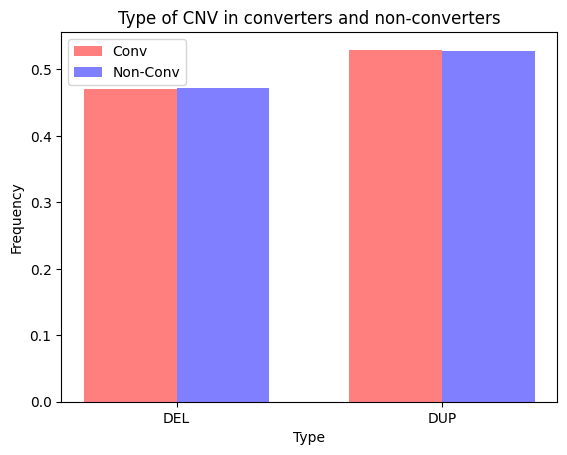

In [4]:
conv_del = sum((df["Type"] == "DEL") & df["Phenotype"].isin(converters)) / len(df[df["Phenotype"].isin(converters)])
conv_dup = sum((df["Type"] == "DUP") & (df["Phenotype"].isin(converters))) / len(df[df["Phenotype"].isin(converters)])
non_conv_del = sum((df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))) / len(df[df["Phenotype"].isin(non_converters)])
non_conv_dup = sum((df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))) / len(df[df["Phenotype"].isin(non_converters)])

conv_counts = [conv_del, conv_dup]
non_conv_counts = [non_conv_del, non_conv_dup]
categories = ["DEL", "DUP"]
width = 0.35  

fig, ax = plt.subplots()
conv_bars = ax.bar(np.arange(len(categories)) - width/2, conv_counts, width, label="Conv", color="red", alpha=0.5)
non_conv_bars = ax.bar(np.arange(len(categories)) + width/2, non_conv_counts, width, label="Non-Conv", color="blue", alpha=0.5)

ax.set_xlabel("Type")
ax.set_ylabel("Frequency")
ax.set_title("Type of CNV in converters and non-converters")
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.legend()

plt.show()


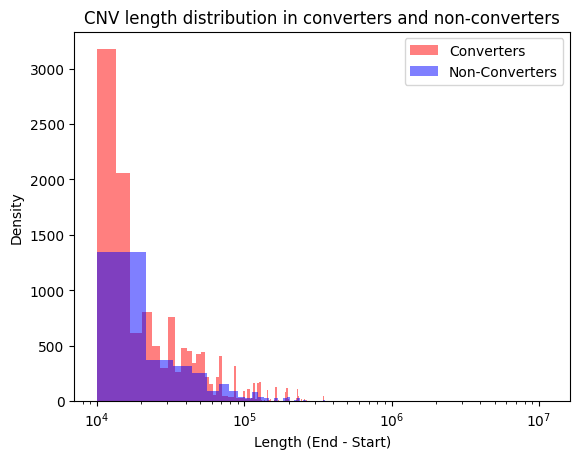

In [5]:
length_converters = df[df["Phenotype"].isin(converters)]["End"] - df[df["Phenotype"].isin(converters)]["Start"]
length_non_converters = df[df["Phenotype"].isin(non_converters)]["End"] - df[df["Phenotype"].isin(non_converters)]["Start"]

plt.hist(length_converters, bins=1000, color="r", alpha=0.5, label="Converters")
plt.hist(length_non_converters, bins=1000, color="b", alpha=0.5, label="Non-Converters")

plt.xscale("log")
plt.xlabel("Length (End - Start)")
plt.ylabel("Density")
plt.title("CNV length distribution in converters and non-converters")
plt.legend()
plt.show()


In [6]:
from scipy.stats import chi2_contingency, fisher_exact
import statsmodels.api as sm

p_values = []

for i, row in df.iterrows():
    
    Count_11 = row["CNV_freq_in_converters"] 
    Count_12 = sum(df_pheno["Phenotype"].isin(converters)) - Count_11
    Count_21 = row["CNV_freq_in_non_converters"] 
    Count_22 = sum(df_pheno["Phenotype"].isin(non_converters)) - Count_21
    
    observed = np.array([[Count_11, Count_12], [Count_21, Count_22]])
    expected = np.outer(observed.sum(axis=0) / observed.sum(), observed.sum(axis=1) / observed.sum())

    min_expected = 5  

    if (expected < min_expected).any():
        # Fisher's exact test
        odds_ratio, p = fisher_exact(observed)
        test_used = "Fisher's Exact Test"
    else:
        # Chi-squared test
        chi2, p, _, _ = chi2_contingency(observed)
        test_used = "Chi-Squared Test"
        
    p_values.append(p)

_, adjusted_p_values, _, _ = sm.stats.multipletests(p_values, method="bonferroni")

for i, adj_p in enumerate(adjusted_p_values):
    if adj_p < 0.05:
        df.loc[i, "Different"] = True
    else:
        df.loc[i, "Different"] = False

NameError: name 'df_pheno' is not defined

In [7]:
df["CNV_freq_in_converters"] = round(df["CNV_freq_in_converters"].astype(int) / sum(df_pheno["Phenotype"].isin(converters)), 3)
df["CNV_freq_in_non_converters"] = round(df["CNV_freq_in_non_converters"].astype(int) / sum(df_pheno["Phenotype"].isin(non_converters)), 3)
df["CNV_length"] = df["End"] - df["Start"]
df.describe()

NameError: name 'df_pheno' is not defined

In [128]:
df_filtered = df[(df["CNV_freq_in_converters"] < 0.1) | (df["CNV_freq_in_non_converters"] < 0.1)]

In [130]:
df_filtered["Classification"].value_counts()

Classification
Benign                    3558
Uncertain significance    2989
Pathogenic                   5
Likely pathogenic            3
Name: count, dtype: int64

In [191]:
df_filtered.reset_index(drop=True, inplace=True)
df_filtered


,ID_WGS,Code,Phenotype,Chromosome,Start,End,Type,Classification,Protein_coding_genes,CNV_freq_in_converters,CNV_freq_in_non_converters,Different
0,S36742,UHR,Converter,chr11,59043182,59086423,DEL,Uncertain significance,GLYATL1B,0.060,0.000,False
1,S36742,UHR,Converter,chr12,11079522,11094765,DEL,Benign,"PRH1, PRH1-TAS2R14, TAS2R43",0.026,0.015,False
2,S36742,UHR,Converter,chr12,2136902,2149309,DEL,Uncertain significance,CACNA1C,0.017,0.015,False
3,S36742,UHR,Converter,chr12,59261514,59610333,DUP,Uncertain significance,SLC16A7,0.003,0.000,False
4,S36742,UHR,Converter,chr17,21290083,21325260,DUP,Uncertain significance,MAP2K3,0.043,0.015,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6550,S37138,FEP,FEP,chr5,757347,794527,DUP,Benign,ZDHHC11B,0.043,0.062,False
6551,S37138,FEP,FEP,chr6,32487549,32521249,DEL,Benign,HLA-DRB5,0.017,0.000,False
6552,S37138,FEP,FEP,chr6,32521250,32532568,DEL,Benign,HLA-DRB5,0.033,0.000,False
6553,S37138,FEP,FEP,chr6,72153159,72165061,DEL,Benign,RIMS1,0.010,0.015,False


In [9]:
df

,ID_WGS,Code,Phenotype,Chromosome,Start,End,Type,Classification,Protein_coding_genes,CNV_freq_in_converters,CNV_freq_in_non_converters
0,S36742,UHR,Converter,chr10,46514588,46561948,DUP,Uncertain significance,GPRIN2,287,62
1,S36742,UHR,Converter,chr11,18922801,18942182,DEL,Benign,MRGPRX1,140,30
2,S36742,UHR,Converter,chr11,56697855,56707946,DUP,Uncertain significance,"OR9G1, OR9G9",214,46
3,S36742,UHR,Converter,chr11,5763025,5788170,DEL,Benign,"OR52N5, OR52N1",117,35
4,S36742,UHR,Converter,chr11,59043182,59086423,DEL,Uncertain significance,GLYATL1B,18,0
...,...,...,...,...,...,...,...,...,...,...,...
18397,S37138,FEP,FEP,chr6,32577150,32589674,DUP,Uncertain significance,HLA-DRB1,76,17
18398,S37138,FEP,FEP,chr6,35785866,35798560,DUP,Benign,"CLPSL1, CLPS",154,38
18399,S37138,FEP,FEP,chr6,72153159,72165061,DEL,Benign,RIMS1,3,1
18400,S37138,FEP,FEP,chr7,100955671,100971252,DUP,Uncertain significance,"MUC3A, MUC12",233,52


In [50]:
api_key = "5c60f73cd9bc7bce4e4a8d496e3dde241709"
db = "gene"
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
retmode = "xml"

request_count = 0

for index, row in tqdm(df.iterrows(), total=len(df)):
    gene_names = df.loc[index,"Protein_coding_genes"].split(", ") 
    id_wgs = df.loc[index,"ID_WGS"]
    genes_id_list = []
    for gene_name in gene_names:
        term = f"(Homo+sapiens%5BOrganism%5D)+AND+{gene_name}%5BGene+Name%5D"
        query_url = (
            f"{base_url}/esearch.fcgi?db={db}&term={term}&retmode={retmode}&api_key={api_key}"
        )
        
        if request_count == 3:
            request_count = 0
            time.sleep(0.001)
            
        response = requests.get(query_url)
        
        request_count += 1
        if response.status_code != 200:
            print(f"Error with {gene_name} in patient {id_wgs}")
        else:
            xml_content = response.content
            xml_content_dict = xmltodict.parse(xml_content)
            gene_id_list = xml_content_dict["eSearchResult"]["IdList"]["Id"]
            genes_id_list.append(gene_id_list) 
        
        if type(genes_id_list[0]) is list:    
            genes_id_list_flattened = [gene_id for gene_id in genes_id_list[0]] 
        else:
            genes_id_list_flattened = [gene_id for gene_id in genes_id_list] 
        df.loc[index, "Genes_ids"] = ", ".join(genes_id_list_flattened)

  0%|          | 10/18402 [00:35<18:00:37,  3.53s/it]


KeyboardInterrupt: 

In [13]:
#https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=gene&id=5479&retmode=xml

db = "gene"
base_url = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "xml"
xml_name = "gene_info.xml"
gene_id = "PRH1"

query_url = (
    f"{base_url}/efetch.fcgi?db={db}&id={gene_id}"
    f"&retmode={retmode}&rettype=abstract&api_key={api_key}"
)

response = requests.get(query_url)
if response.status_code != 200:
    print("Error")
with open(xml_name, "w") as xml_file:
    xml_file.write(response.text)

NameError: name 'api_key' is not defined

In [10]:
gene_name = "PRH1"

server = "https://rest.ensembl.org"
ext = "/xrefs/symbol/homo_sapiens/"

r = requests.get(server+ext+gene_name, headers={ "Content-Type" : "application/json"})

if not r.ok:
    r.raise_for_status()
    sys.exit()

decoded = r.json()
decoded

[{'id': 'ENSG00000111215', 'type': 'gene'},
 {'type': 'gene', 'id': 'ENSG00000231887'},
 {'type': 'gene', 'id': 'ENSG00000282269'},
 {'id': 'ENSG00000277823', 'type': 'gene'},
 {'id': 'ENSG00000263247', 'type': 'gene'}]

In [11]:
tissue_data = [(entry["tissueSiteDetailId"], entry["data"]) for entry in response_data["data"]]
tissue_medians = [(tissue_name, np.median(data)) for tissue_name, data in tissue_data]
sorted_tissues = sorted(tissue_medians, key=lambda x: x[1], reverse=True)
top_5_tissues = sorted_tissues[:10]
for tissue, median in top_5_tissues:
    print(tissue)


NameError: name 'response_data' is not defined